# Data

This file contains all the code necessary to convert the [NYU hand pose dataset](http://cims.nyu.edu/~tompson/NYU_Hand_Pose_Dataset.htm) into a single [.hdf5](http://www.h5py.org/) file for use by [model.ipynb](model).

In [1]:
import h5py
import numpy as np
import pandas as pd
import scipy.misc
import scipy.io as sio
from keras.utils.generic_utils import Progbar
from PIL import Image
import sys
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d, Axes3D
from os import path
%matplotlib inline

Using TensorFlow backend.


### Input dataset

The default input dataset directory, containing the NYU hand pose dataset, is assumed to be a folder called nyu_hand_dataset_v2/ in the project root.

Simply unzipping the NYU dataset into the project root should be enough to get up and running without any extra configuration.

#### Training data

Training data is located in the dataset/train/ subfolder of the NYU dataset.

There are 72757 training images and corresponding labels.

#### Testing data

Testing data is located in the dataset/test/ subfolder of the NYU dataset.

There are 8252 testing images and corresponding labels.

In [2]:
INPUT_DIR   = 'nyu_hand_dataset_v2/dataset'
data_path   = lambda *args : path.join(INPUT_DIR, *args)
image_path  = lambda type, angle, index : '%s_%d_%07d.png' % (type, angle, index + 1)
labels_path = 'joint_data.mat'

In [3]:
def load_data(set, type, angle, dtype='uint16'):
    labels = load_labels(set, angle)
    image_paths = (data_path(set, image_path(type, angle, i)) for i in range(len(labels)))
    images = load_images(image_paths, dtype)
    return images, labels

#### Images

Each image is $ 640 \times 480 \times 3 $, stored in the standard .png format as unsigned 8 bit integers.

Images contain either RGB, depth, or synthetic depth data, from a front, top, or side viewing angle.

Images are named as [type]\_[angle]\_[number].png.

Type may be one of:

* rgb
* depth
* synthdepth

Angle may be one of:

* 1 (front)
* 2 (top)
* 3 (side)

Numbers start at 1 and are padded with zeroes to 7 digits.

In [4]:
def load_images(image_paths, dtype='uint16'):
    for image_path in image_paths:
        with Image.open(image_path) as image:
            yield np.asarray(image, dtype)

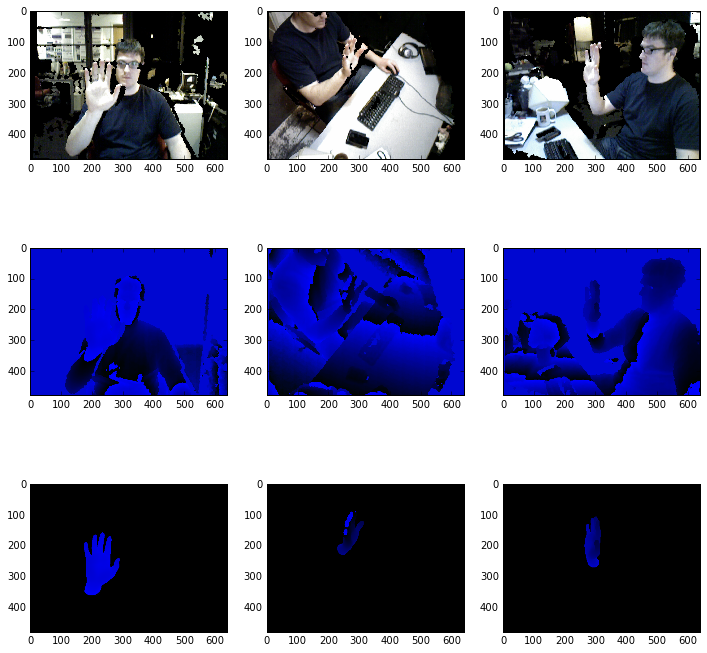

In [5]:
demo_images = load_images([data_path('train', image_path(type, angle, 0)) \
                           for type in ['rgb', 'depth', 'synthdepth'] \
                           for angle in range(1, 4)], 'uint8')

plt.figure(figsize=(12, 12))
for i, demo_image in enumerate(demo_images):
    plt.subplot(331 + i)
    plt.imshow(demo_image)

#### Depth images

Depth images and synthetic depth images [store the most significant bits of depth data in the green channel and the least significant bits in the blue channel](https://github.com/jsupancic/deep_hand_pose/blob/master/src/caffe/jvl.cpp#L507).

In [6]:
def convert_depth(image):
    return np.expand_dims((image[:, :, 1] << 8) + image[:, :, 2], 2)

#### Labels

Each label is $ 36 \times 3 $, stored in the MATLAB .mat format as double precision floating point numbers in a file named joint_data.mat. There is one label for each of the three camera angles.

Each 3-tuple is a point in the $ uvd $ coordinate space, which is the same as that used in the [depth images](#Depth-images). $ u $ and $ v $ are in pixels, while $ d $ is in millimeters.

There are 36 tuples per label, corresponding to keypoints on the hand. Each finger is represented by 6 keypoints, 2 for each finger segment. Three points represent the palm and three represent the wrist.

Finger keypoints are named as [finger]\_[segment]\_[component].

Finger may be one of:

* F1 (pinky)
* F2 (ring)
* F3 (middle)
* F4 (index)
* TH (thumb)

Segment may be one of:

* KNU3 (fingertip / distal phalanx)
* KNU2 (finger middle / middle phalanx)
* KNU1 (finger base / proximal phalanx)

Component may be one of:

* A (bone neck)
* B (joint / bone base)

Palm and wrist keypoints are named as follows:

* PALM_1 (outer / ulnar wrist)
* PALM_2 (inner / radial wrist)
* PALM_3 (inner / radial palm)
* PALM_4 (outer / ulnar palm)
* PALM_5 (middle palm / ring metacarpal)
* PALM_6 (middle wrist / lunate)

In [7]:
def load_labels(set, angle):
    joint_data  = sio.loadmat(data_path(set, labels_path))
    labels      = joint_data['joint_uvd'][angle - 1]
    joint_names = [name[0] for name in joint_data['joint_names'][0]]

    return pd.Panel(labels, major_axis=joint_names, minor_axis=['u', 'v', 'd'])

<a id="input-images"></a>

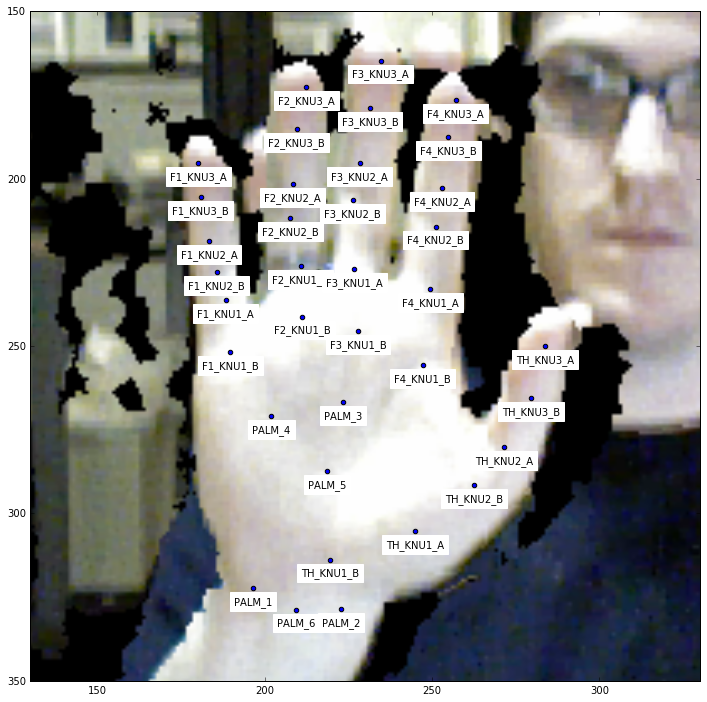

In [8]:
demo_image = load_images([data_path('train', image_path('rgb', 1, 0))], 'uint8').__next__()
demo_label = load_labels('train', 1)[0]

plt.figure(figsize=(12, 12))
plt.gca().invert_yaxis()
plt.axis('equal')
plt.scatter(demo_label.ix[:, 'u'], demo_label.ix[:, 'v'])
plt.gca().set_autoscale_on(False)
plt.imshow(demo_image.squeeze())

for joint_name, joint_data in zip(demo_label.axes[0].values, demo_label.ix[:, ['u', 'v']].values):
    plt.annotate(joint_name,
                 joint_data,
                 xytext=(0, -8),
                 textcoords='offset points',
                 size=10,
                 backgroundcolor='white',
                 ha='center',
                 va='top')

### Output dataset

The default [dataset](http://docs.h5py.org/en/latest/high/dataset.html) output directory is the dataset subfolder of the project root. The dataset is written to an [.hdf5](http://www.h5py.org/) file named dataset.hdf5.

This file contains the following [groups](http://docs.h5py.org/en/latest/high/group.html):

* image
    * train
    * test
* label
    * train
    * test
* pca
    * eigenvectors
    * mean
    
#### Images

Each image is $ 128 \times 128 \times 1 $, containing depth data from the front angle, stored as single precision floating point numbers.

#### Labels

Each label is $ 28 \times 1 $, containing the $ u $ and $ v $ values from the following hand keypoints, stored as single precision floating point numbers:

* F1_KNU3_A
* F1_KNU2_B
* F2_KNU3_A
* F2_KNU2_B
* F3_KNU3_A
* F3_KNU2_B
* F4_KNU3_A
* F4_KNU2_B
* TH_KNU3_A
* TH_KNU3_B
* TH_KNU2_B
* PALM_1
* PALM_2
* PALM_3

In [9]:
DATASET_DIR = 'dataset'
dataset     = h5py.File(path.join(DATASET_DIR, 'dataset.hdf5'))

In [10]:
def process(set):
    images, labels = load_data(set, 'depth', 1)

    data_image = dataset.require_dataset('image/' + set, (len(labels), 128, 128, 1), dtype='float')
    data_label = dataset.require_dataset('label/' + set, (len(labels), 28), dtype='float')

    p = Progbar(len(labels))

    for image, item in zip(images, labels.iteritems()):
        index, label = item
        
        image = convert_depth(image)
        data_image[index], data_label[index] = normalize(image, label)
        
        p.update(index)

#### Normalization

The [Deep Hand Pose](https://github.com/jsupancic/deep_hand_pose) project performs a number of normalization steps on the NYU dataset before it is fed into the model.

Broadly, these consist of:

* Rescaling [image](https://github.com/jsupancic/deep_hand_pose/blob/master/src/caffe/jvl.cpp#L510)  and [label](https://github.com/jsupancic/deep_hand_pose/blob/master/src/caffe/jvl.cpp#L621) depth from millimeters to centimeters
* [Recentering](https://github.com/jsupancic/deep_hand_pose/blob/master/src/caffe/jvl.cpp#L631) around the [middle finger base](https://github.com/jsupancic/deep_hand_pose/blob/master/src/caffe/jvl.cpp#L630)
* [Clipping](https://github.com/jsupancic/deep_hand_pose/blob/master/src/caffe/jvl.cpp#L650) to [a smaller, depth-dependent bounding box](https://github.com/jsupancic/deep_hand_pose/blob/master/src/caffe/jvl.cpp#L638)
* [Clamping](https://github.com/jsupancic/deep_hand_pose/blob/master/src/caffe/jvl.cpp#L665) depth data and scaling it to a range of -1 to 1
* [Resizing](https://github.com/jsupancic/deep_hand_pose/blob/master/src/caffe/layers/hand_data_layer.cpp#L422) the image and label to $ 128 \times 128 $
* [Extracting a subset of the hand pose keypoints](https://github.com/jsupancic/deep_hand_pose/blob/master/include/jvl/blob_io.hpp#L8)

In [11]:
def normalize(image, label):
    label = label.copy()
    
    label.ix[:, 'd'] /= 10.
    image = image / 10.
    
    center = label.ix['F3_KNU1_B', ['v', 'u', 'd']]
    center.ix['d'] = label.ix[:, 'd'].median()

    bounds = bounding_box(center, 525, 38).astype(int)
    image, label = clip(image, label, bounds)
    
    image -= center.ix['d']
    image = np.clip(image, -15, 15) / 15.0
    image, label = resize(image, label, (128, 128))

    image = np.expand_dims(image, 2)
    label = label.ix[[
            'F1_KNU3_A',
            'F1_KNU2_B',
            'F2_KNU3_A',
            'F2_KNU2_B',
            'F3_KNU3_A',
            'F3_KNU2_B',
            'F4_KNU3_A',
            'F4_KNU2_B',
            'TH_KNU3_A',
            'TH_KNU3_B',
            'TH_KNU2_B',
            'PALM_1',
            'PALM_2',
            'PALM_3'
        ], ['u', 'v']].values.flatten()
    
    return image, label

In [12]:
# Get a bounding box of the specified dimensions in centimeters around
# a point in uvd space
def bounding_box(center, fx, size):
    bounding_box = np.array([[0, 0], [1, 1]], dtype='float')
    bounding_box -= 0.5
    bounding_box *= size
    bounding_box *= fx / center[-1]
    bounding_box += center[:-1]
    
    return bounding_box

In [13]:
# Resize an image to the specified dimensions, scaling its label accordingly
def resize(image, label, dimensions):
    label.ix[:, ['v', 'u']] *= np.array(dimensions) / image.shape[:-1]
    
    # TODO: Try to implement or use OpenCV's INTER_AREA resize strategy?
    image = scipy.misc.imresize(np.squeeze(image), dimensions, 'bilinear', mode='F')
    
    return image, label

In [14]:
# Clip an image to the specified bounding box, translating its label accordingly
# Bounding box should look like np.array([[x_1, y_1], [x_2, y_2]]), where
# (x_1, y_1) are the coordinates of the lower left corner and 
# (x_2, y_2) are the coordinates of the upper right corner
def clip(image, label, bounding_box):
    label.ix[:, ['v', 'u']] -= bounding_box[0]
    
    image_box = np.array([[0, 0], image.shape[:-1]], dtype='int')
    
    padding = np.array([image_box[0] - bounding_box[0], bounding_box[1] - image_box[1]]).clip(0)
    bounding_box += padding[0]
    padding = np.concatenate((padding.T, np.array([[0, 0]])))
    
    image = np.pad(image, padding, 'edge')
    image = image[slice(*bounding_box[:, 0]), slice(*bounding_box[:, 1])]
    
    return image, label

In [15]:
process('train')
process('test')

8251/8252 [============================>.] - ETA: 0s

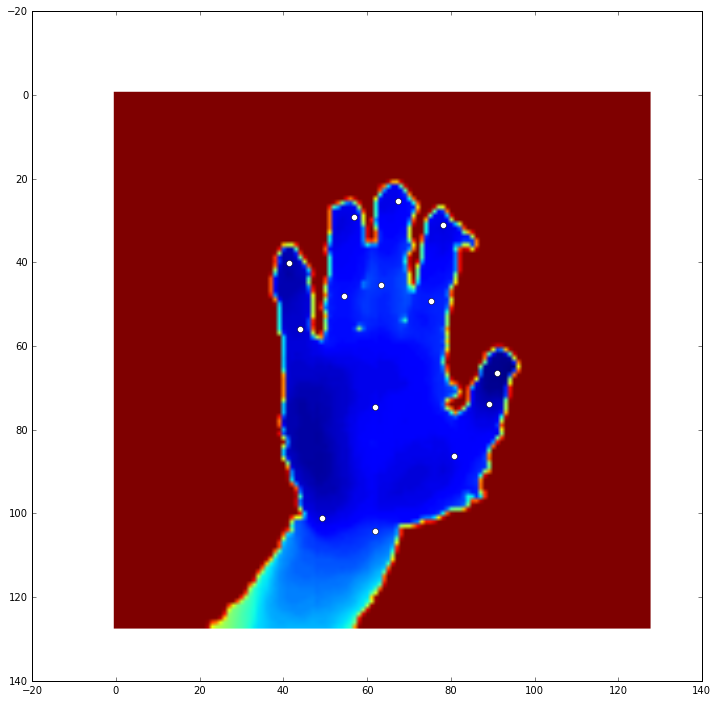

In [18]:
demo_image = dataset['image/train'][0]
demo_label = dataset['label/train'][0]

plt.figure(figsize=(12, 12))
plt.imshow(demo_image.squeeze())
plt.plot(demo_label[::2], demo_label[1::2], 'wo')

In [19]:
dataset.close()